# Import Libraries

In [3]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

# Create the Data

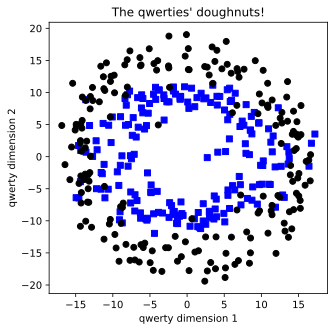

In [4]:
# create data

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# Separate the data into DataLoaders

In [5]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16 #int(train_data.tensors[0].shape[0]/4) -- Hard-coding is better to avoid huge batches!
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

# 1. Dropout

In [6]:
# Create the model
class theModelClass(nn.Module):
  def __init__(self,dropoutRate):
    super().__init__()

    ### layers
    self.input  = nn.Linear(  2,128)
    self.hidden = nn.Linear(128,128)
    self.output = nn.Linear(128, 1)

    # parameters
    self.dr = dropoutRate

  # forward pass
  def forward(self,x):

    # pass the data through the input layer
    x = F.relu( self.input(x) )

    # dropout after input layer
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    
    # pass the data through the hidden layer
    x = F.relu( self.hidden(x) )

    # dropout after hidden layer
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    
    # output layer
    x = self.output(x)
    # no dropout here!!
    return x

In [7]:
def createANewModel(dropoutrate):

  # grab an instance of the model class
  ANNQC = theModelClass(dropoutrate)

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNQC.parameters(),lr=.002)

  return ANNQC,lossfun,optimizer

### 1.1 Functions to create and train the net

In [9]:
# train the model

# training parameter
numepochs = 1000

# NOTE: this time, the model, lossfun, and optimizer are inputs into the function!
def trainTheModel(ANNQC,lossfun,optimizer):

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch training mode on (is this the right place for this code??)
    ANNQC.train() 

    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNQC(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    ANNQC.eval() # switch training off
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = ANNQC(X)
    testAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
  
  # function output
  return trainAcc,testAcc

### 1.2 Test the model

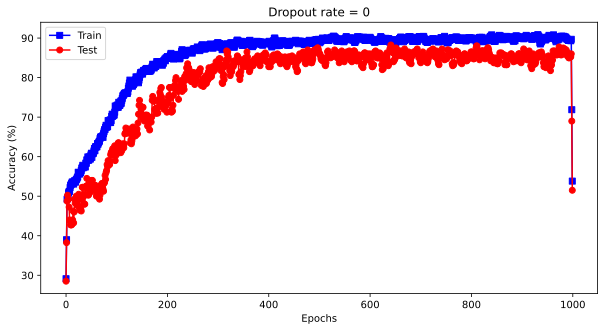

In [10]:
# create a model
dropoutrate = .0
ANNQC,lossfun,optimizer = createANewModel(dropoutrate)

# train the model (note the inputs!)
trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

### 1.3 DropOut Experiment

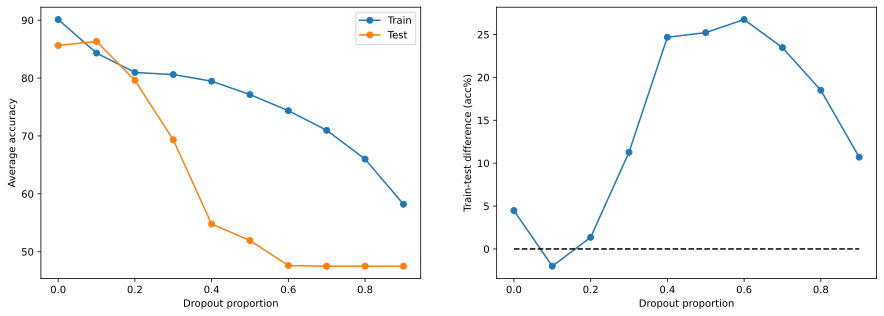

In [11]:
# run an experiment (note: takes ~3.5 mins)

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # create and train the model
  ANNQC,lossfun,optimizer = createANewModel(dropoutRates[di])
  trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

  # store accuracies from last 100 epochs
  results[di,0] = np.mean(trainAcc[-100:])
  results[di,1] = np.mean(testAcc[-100:])


# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

# 2. L2 Regularization (Ridge)

In [12]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# a function that creates the ANN model

def createANewModel(L2lambda):

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer --- L2 penalized 
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005,weight_decay=L2lambda)

  return ANNiris,lossfun,optimizer


# train the model

# global parameter
numepochs = 1000

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # need to toggle train mode here??

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    ANNiris.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

    # no worries, reset here ;)
    ANNiris.train() 
  
  # function output
  return trainAcc,testAcc,losses

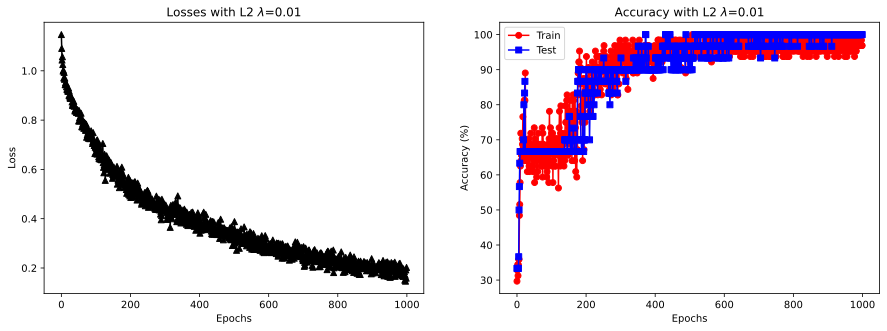

In [13]:
# create a model
L2lambda = .01
ANNiris,lossfun,optimizer = createANewModel(L2lambda)

# train the model
trainAcc,testAcc,losses = trainTheModel()

# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

### 2.1 L2 Regularization Experiment

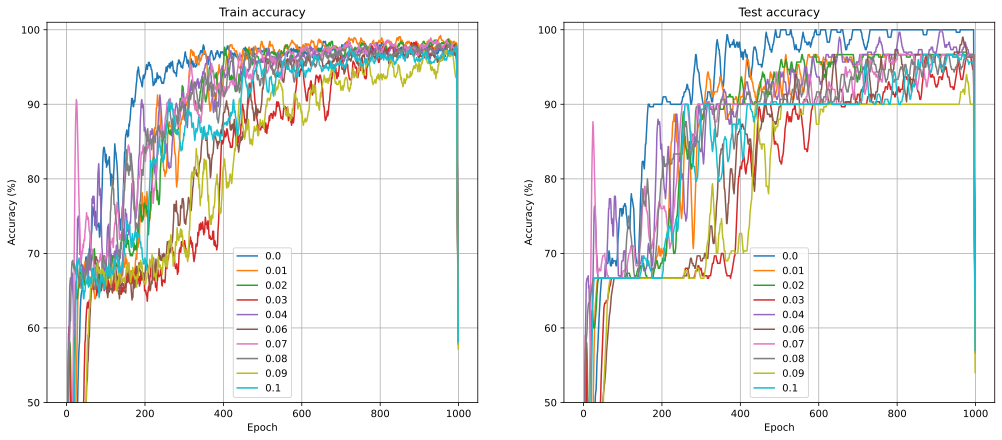

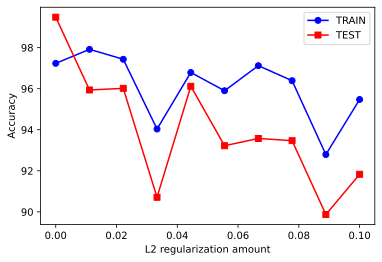

In [14]:
# range of L2 regularization amounts
l2lambdas = np.linspace(0,.1,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(l2lambdas)))
accuracyResultsTest  = np.zeros((numepochs,len(l2lambdas)))


# loop over batch sizes
for li in range(len(l2lambdas)):

  # create and train a model
  ANNiris,lossfun,optimizer = createANewModel(l2lambdas[li])
  trainAcc,testAcc,losses = trainTheModel()

  # store data
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li]  = smooth(testAcc,10)


 # plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,2) for i in l2lambdas]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()



# show average accuracy by L2 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 3. L1 Regularization (Lasso)

In [17]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005)

  return ANNiris,lossfun,optimizer


In [18]:
# train the model

# global parameter
numepochs = 1000

def trainTheModel(L1lambda):

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # count the total number of weights in the model
  nweights = 0
  for pname,weight in ANNiris.named_parameters():
    if 'bias' not in pname:
      nweights = nweights + weight.numel()


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)



      ### add L1 term
      L1_term = torch.tensor(0.,requires_grad=True)

      # sum up all abs(weights)
      for pname,weight in ANNiris.named_parameters():
        if 'bias' not in pname:
           L1_term = L1_term + torch.sum(torch.abs(weight))
      
      # add to loss term
      loss = loss + L1lambda*L1_term/nweights
      


      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses


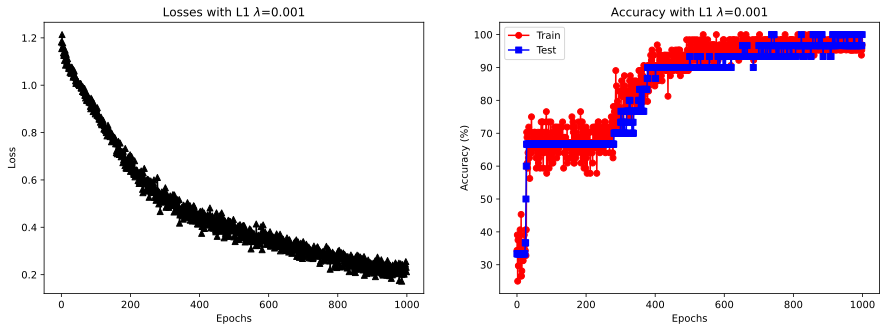

In [19]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
L1lambda = .001
trainAcc,testAcc,losses = trainTheModel(L1lambda)

# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

### 3.1 L1 Experiment

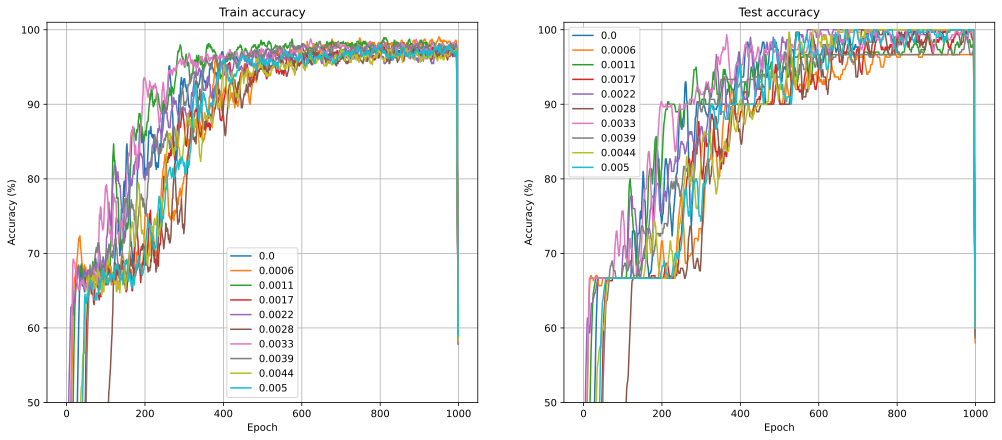

In [23]:
# range of L1 regularization amounts
L1lambda = np.linspace(0,.005,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(L1lambda)))
accuracyResultsTest  = np.zeros((numepochs,len(L1lambda)))


# loop over batch sizes
for li in range(len(L1lambda)):

  # create and train a model
  ANNiris,lossfun,optimizer = createANewModel()
  trainAcc,testAcc,losses = trainTheModel(L1lambda[li])

  # store data
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li]  = smooth(testAcc,10)

# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,4) for i in L1lambda]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

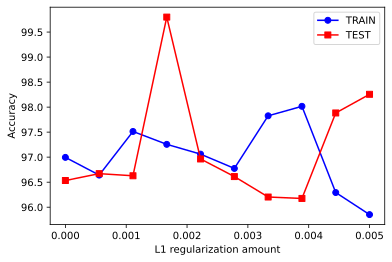

In [22]:
# show average accuracy by L1 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(L1lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L1lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 4. Mini-Batch

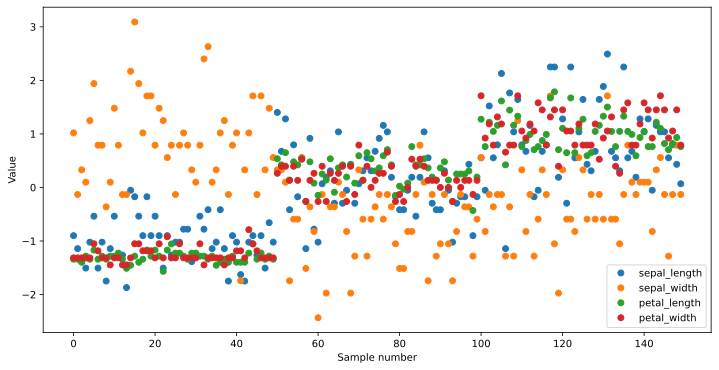

In [24]:
# z-score the data
import scipy.stats as stats
cols2zscore = iris.keys()
cols2zscore = cols2zscore.drop('species')
iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [25]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [26]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

### 4.1 Construct the model and training plans

In [27]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.0005)

  return ANNiris,lossfun,optimizer


# train the model

# global parameter
numepochs = 2500

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

### 4.2 Test on Mini-Batch

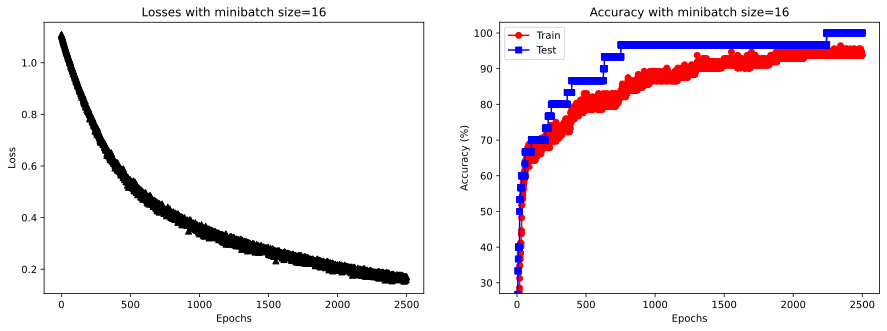

In [28]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc,losses = trainTheModel()


# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()

### 4.3 Test Batch

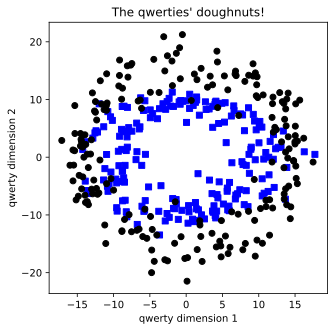

In [38]:
# create data

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [39]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
train_batchsize = 16
test_batchsize  = test_data.tensors[0].shape[0]
train_loader = DataLoader(train_data,batch_size=train_batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_batchsize)

In [40]:
class theModelClass(nn.Module):
  def __init__(self):
    super().__init__()

    ### layers
    self.input  = nn.Linear(  2,128)
    self.hidden = nn.Linear(128,128)
    self.output = nn.Linear(128, 1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.hidden(x) )
    x = self.output(x)
    return x


In [41]:
# a function that creates the ANN model

def createANewModel():

  # grab an instance of the model class
  ANNQC = theModelClass()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNQC.parameters(),lr=.01)

  return ANNQC,lossfun,optimizer

In [42]:
# train the model

# global parameter
numepochs = 500

# NOTE: this time, the model, lossfun, and optimizer are inputs into the function!
def trainTheModel(ANNQC,lossfun,optimizer):

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNQC(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy (NOTE: testing in batches!)
    tstacc = []
    for X,y in test_loader:
      yHat = ANNQC(X)
      tstacc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # now get the average accuracy over test-batches
    testAcc.append(np.mean(tstacc))
  
  # function output
  return trainAcc,testAcc


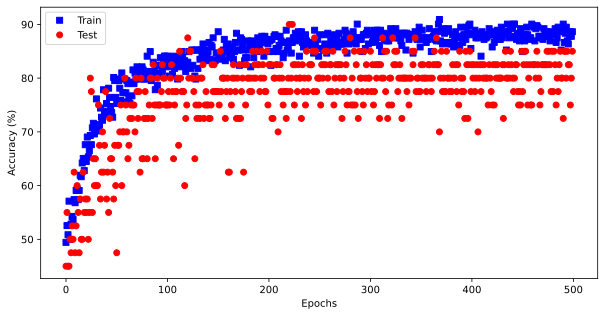

In [43]:
# create a model
ANNQC,lossfun,optimizer = createANewModel()

# train the model (note the inputs!)
trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs')
plt.plot(testAcc,'ro')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

plt.show()